In [3]:
import glob
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# get data file names
path = 'T81-585 Capstone - Fall 2022'
all_files = glob.glob(
    os.path.join(path, "uwsl_weighting_sample*"))
print(all_files)

# Merge all file with same format
df_from_each_file = (pd.read_table(f, sep='|', low_memory=False) for f in all_files)
concatenated_df = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df = pd.DataFrame(concatenated_df)

# Drop n/a
concatenated_df = concatenated_df.dropna()

# Reform post_mount to datatime
# concatenated_df['post_month'] = pd.to_datetime(concatenated_df['post_month'].astype(str), format='%Y%m')
# concatenated_df['post_month'] = concatenated_df['post_month'].dt.strftime('%Y/%m')
concatenated_df['post_month'] = pd.to_datetime(concatenated_df['post_month'], format='%Y%m')

# Chooes all species = dog
concatenated_df = concatenated_df.loc[concatenated_df['species']=='Dog']
concatenated_df = concatenated_df.drop(columns='species')

# Remove columns 'is_bd_outlier', 'is_account_outlier'
concatenated_df = concatenated_df.drop(columns=['is_bd_outlier', 'is_account_outlier'])

# Seprate account_id to source_id and account_id
concatenated_df.insert(1, 'source_id', '')
concatenated_df['source_id'] = concatenated_df['account_id'].map(lambda  x:x. split('-')[0])
concatenated_df['account_id'] = concatenated_df['account_id'].map(lambda  x:x. split('-')[1])

# Drop manufactory with small data samples
concatenated_df = concatenated_df.drop(concatenated_df[(concatenated_df.icms_rep_mfg == 'MavLab') | (concatenated_df.icms_rep_mfg == 'Vethical')].index)

concatenated_df.to_pickle("E:\\WUSTL\\2022 FALL\\INFO 585\\Project\\Pet_Food_Market\\merged_data.pkl")
# concatenated_df

['T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201701.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201702.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201703.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201704.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201705.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201706.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201707.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201708.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201709.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201710.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201711.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201712.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201801.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201802.txt', 'T81-585 Capstone - Fall 2022\\uwsl_weighting_sample_201803.txt', 'T81-585 

In [5]:
path = 'T81-585 Capstone - Fall 2022/uwsl_valid_clinics.txt'
df_valid_clinics = pd.read_table(path, sep='|')
df_valid_clinics = pd.DataFrame(df_valid_clinics)
df_valid_clinics = df_valid_clinics.drop(columns=['geoglarge', 'keep'])
df_valid_clinics.to_pickle("E:\\WUSTL\\2022 FALL\\INFO 585\\Project\\Pet_Food_Market\\valid_clinics.pkl")
# df_valid_clinics

In [6]:
concatenated_df['unit_price'] = concatenated_df['revenue'] / concatenated_df['units']
concatenated_df['unit_price'].apply(lambda x: float(x))

0            2.268182
1            3.480000
3            0.575000
4            2.050746
5            2.399533
              ...    
65398988    46.440000
65398989    22.541429
65398990    20.030000
65398992     3.890000
65398995     5.180000
Name: unit_price, Length: 43889675, dtype: float64

In [7]:
product_Classifi = concatenated_df.groupby(['icms_rep_mfg', 'icms_rep_brand', 'icms_form', 'patient_age_type'], as_index=False)[['units', 'revenue']].sum()
lst_Product_mfg = product_Classifi['icms_rep_mfg'].tolist()
lst_Product_brand = product_Classifi['icms_rep_brand'].tolist()
lst_Product_form = product_Classifi['icms_form'].tolist()
lst_Product_age = product_Classifi['patient_age_type'].tolist()
product_Classifi

,icms_rep_mfg,icms_rep_brand,icms_form,patient_age_type,units,revenue
0,American Regent,Adequan,Injection,Adult,2.696035e+06,7.977110e+07
1,American Regent,Adequan,Injection,Non-adult,4.115484e+04,6.323500e+05
2,BI,Cefa-Cap,Pill,Adult,2.752172e+05,2.134370e+05
3,BI,Cefa-Cap,Pill,Non-adult,2.319600e+04,1.832981e+04
4,BI,Cefa-Drop,Oral Liquid,Adult,6.785814e+03,9.401507e+04
...,...,...,...,...,...,...
970,Zoetis,Torbutrol,Injection,Non-adult,1.729780e+04,4.870669e+05
971,Zoetis,Torbutrol,Pill,Adult,5.398074e+03,6.078779e+04
972,Zoetis,Torbutrol,Pill,Non-adult,3.516170e+02,8.473558e+03
973,Zoetis,Zeniquin,Pill,Adult,5.424681e+06,3.013750e+07


In [8]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
outlier_rate = pd.DataFrame()
for i in range(0, 975):
    print("i = ", i, "lst_Product_mfg = ", lst_Product_mfg[i], "lst_Product_form = ", lst_Product_brand[i], "lst_Product_form = ", lst_Product_form[i], "lst_Product_age = ", lst_Product_age[i])
    temp = concatenated_df.loc[(concatenated_df['icms_rep_mfg']==lst_Product_mfg[i]) & (concatenated_df['icms_rep_brand']==lst_Product_brand[i]) & (concatenated_df['icms_form']==lst_Product_form[i]) & (concatenated_df['patient_age_type']==lst_Product_age[i])].copy()
    model.fit(temp[['revenue', 'units']])
    temp['scores']=model.decision_function(temp[['revenue', 'units']])
    temp['anomaly']=model.predict(temp[['revenue', 'units']])
    outlier_rate = pd.concat([outlier_rate, temp])
    print("In ith turn, the length of outlier_rate = ", len(outlier_rate))
outlier_rate

i =  0 lst_Product_mfg =  American Regent lst_Product_form =  Adequan lst_Product_form =  Injection lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  228504
i =  1 lst_Product_mfg =  American Regent lst_Product_form =  Adequan lst_Product_form =  Injection lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  234259
i =  2 lst_Product_mfg =  BI lst_Product_form =  Cefa-Cap lst_Product_form =  Pill lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  234792
i =  3 lst_Product_mfg =  BI lst_Product_form =  Cefa-Cap lst_Product_form =  Pill lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  235115
i =  4 lst_Product_mfg =  BI lst_Product_form =  Cefa-Drop lst_Product_form =  Oral Liquid lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  237291
i =  5 lst_Product_mfg =  BI lst_Product_form =  Cefa-Drop lst_Product_form =  Oral Liquid lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate 

C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  2102425
i =  30 lst_Product_mfg =  BI lst_Product_form =  NexGard lst_Product_form =  Chewable lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  2479162
i =  31 lst_Product_mfg =  BI lst_Product_form =  NexGard lst_Product_form =  Chewable lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  2842900
i =  32 lst_Product_mfg =  BI lst_Product_form =  Previcox lst_Product_form =  Pill lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  3084032
i =  33 lst_Product_mfg =  BI lst_Product_form =  Previcox lst_Product_form =  Pill lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  3161212
i =  34 lst_Product_mfg =  BI lst_Product_form =  PromAce lst_Product_form =  Pill lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  3163687
i =  35 lst_Product_mfg =  BI lst_Product_form =  PromAce lst_Product_form =  Pill lst_Product_age =  Non-adult
In ith turn, the length 

C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  3252574
i =  66 lst_Product_mfg =  Blue Buffalo lst_Product_form =  WM Weight + Mobility lst_Product_form =  Wet lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  3252692
i =  67 lst_Product_mfg =  Blue Buffalo lst_Product_form =  WM Weight + Mobility lst_Product_form =  Wet lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  3252694
i =  68 lst_Product_mfg =  Blue Buffalo lst_Product_form =  WU Weight + Urinary lst_Product_form =  Dry lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  3256560
i =  69 lst_Product_mfg =  Blue Buffalo lst_Product_form =  WU Weight + Urinary lst_Product_form =  Dry lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  3256683
i =  70 lst_Product_mfg =  Blue Buffalo lst_Product_form =  WU Weight + Urinary lst_Product_form =  Wet lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  3259121
i =  71 lst_Product_mfg =  Blue Buffalo

C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  3272769
i =  77 lst_Product_mfg =  CAP IM lst_Product_form =  Provecta Unspecified lst_Product_form =  Topical lst_Product_age =  Non-adult


C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  3272770
i =  78 lst_Product_mfg =  Ceva lst_Product_form =  Combiva II lst_Product_form =  Topical lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  3272953
i =  79 lst_Product_mfg =  Ceva lst_Product_form =  Combiva II lst_Product_form =  Topical lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  3273053
i =  80 lst_Product_mfg =  Ceva lst_Product_form =  Milbeguard lst_Product_form =  Flavor Tablet lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  3277987
i =  81 lst_Product_mfg =  Ceva lst_Product_form =  Milbeguard lst_Product_form =  Flavor Tablet lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  3281624
i =  82 lst_Product_mfg =  Ceva lst_Product_form =  Synovial Flex Advanced lst_Product_form =  Unspecified lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  3287806
i =  83 lst_Product_mfg =  Ceva lst_Product_form =  Synovial Flex Advanced lst

C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  19759315
i =  391 lst_Product_mfg =  Multiple lst_Product_form =  Ciprofloxacin lst_Product_form =  Oral Liquid lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  19759508
i =  392 lst_Product_mfg =  Multiple lst_Product_form =  Ciprofloxacin lst_Product_form =  Oral Liquid lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  19759534
i =  393 lst_Product_mfg =  Multiple lst_Product_form =  Ciprofloxacin lst_Product_form =  Pill lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  19878591
i =  394 lst_Product_mfg =  Multiple lst_Product_form =  Ciprofloxacin lst_Product_form =  Pill lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  19892672
i =  395 lst_Product_mfg =  Multiple lst_Product_form =  Clemastine lst_Product_form =  Pill lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  19894840
i =  396 lst_Product_mfg =  Multiple lst_Product_form =  Clemast

C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  30442500
i =  572 lst_Product_mfg =  Multiple lst_Product_form =  Triamcinolone lst_Product_form =  Pill lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  30455886
i =  573 lst_Product_mfg =  Multiple lst_Product_form =  Triamcinolone lst_Product_form =  Pill lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  30457402
i =  574 lst_Product_mfg =  Multiple lst_Product_form =  Unspecified lst_Product_form =  Unspecified lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  30457443
i =  575 lst_Product_mfg =  Multiple lst_Product_form =  Unspecified lst_Product_form =  Unspecified lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  30457458
i =  576 lst_Product_mfg =  Multiple lst_Product_form =  Unspecified Flea Tick lst_Product_form =  Unspecified lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  30458677
i =  577 lst_Product_mfg =  Multiple lst_Product_f

C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  32785952
i =  686 lst_Product_mfg =  Royal Canin lst_Product_form =  Calm lst_Product_form =  Dry lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  32792722
i =  687 lst_Product_mfg =  Royal Canin lst_Product_form =  Calm lst_Product_form =  Dry lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  32792914
i =  688 lst_Product_mfg =  Royal Canin lst_Product_form =  Calorie Control lst_Product_form =  Dry lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  32792978
i =  689 lst_Product_mfg =  Royal Canin lst_Product_form =  Calorie Control lst_Product_form =  Dry lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  32792983
i =  690 lst_Product_mfg =  Royal Canin lst_Product_form =  Calorie Control lst_Product_form =  Wet lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  32793036
i =  691 lst_Product_mfg =  Royal Canin lst_Product_form =  Calorie Control l

C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  34204406
i =  755 lst_Product_mfg =  Royal Canin lst_Product_form =  Mobility Large Breed lst_Product_form =  Dry lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  34211876
i =  756 lst_Product_mfg =  Royal Canin lst_Product_form =  Mobility Large Breed lst_Product_form =  Dry lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  34211985
i =  757 lst_Product_mfg =  Royal Canin lst_Product_form =  Multifunction Advanced Mobility + Satiety lst_Product_form =  Dry lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  34212257
i =  758 lst_Product_mfg =  Royal Canin lst_Product_form =  Multifunction Advanced Mobility + Satiety lst_Product_form =  Dry lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  34212259
i =  759 lst_Product_mfg =  Royal Canin lst_Product_form =  Multifunction Renal + HP lst_Product_form =  Dry lst_Product_age =  Adult
In ith turn, the length of outlier_r

C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  34224383
i =  764 lst_Product_mfg =  Royal Canin lst_Product_form =  Multifunction Satiety + HP lst_Product_form =  Dry lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  34225478
i =  765 lst_Product_mfg =  Royal Canin lst_Product_form =  Multifunction Satiety + HP lst_Product_form =  Dry lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  34225486
i =  766 lst_Product_mfg =  Royal Canin lst_Product_form =  Multifunction Urinary + HP lst_Product_form =  Dry lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  34257253
i =  767 lst_Product_mfg =  Royal Canin lst_Product_form =  Multifunction Urinary + HP lst_Product_form =  Dry lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  34257526
i =  768 lst_Product_mfg =  Royal Canin lst_Product_form =  Multifunction Urinary + HP Small Breed lst_Product_form =  Dry lst_Product_age =  Adult
In ith turn, the length of outlier_rate 

C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  36087749
i =  896 lst_Product_mfg =  Virbac lst_Product_form =  Preventic Spray lst_Product_form =  Topical lst_Product_age =  Non-adult


C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\mynzy\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


In ith turn, the length of outlier_rate =  36087750
i =  897 lst_Product_mfg =  Virbac lst_Product_form =  Rilexine lst_Product_form =  Pill lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  36155190
i =  898 lst_Product_mfg =  Virbac lst_Product_form =  Rilexine lst_Product_form =  Pill lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  36187617
i =  899 lst_Product_mfg =  Virbac lst_Product_form =  Senergy lst_Product_form =  Topical lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  36188920
i =  900 lst_Product_mfg =  Virbac lst_Product_form =  Senergy lst_Product_form =  Topical lst_Product_age =  Non-adult
In ith turn, the length of outlier_rate =  36190426
i =  901 lst_Product_mfg =  Zoetis lst_Product_form =  Albon lst_Product_form =  Injection lst_Product_age =  Adult
In ith turn, the length of outlier_rate =  36191981
i =  902 lst_Product_mfg =  Zoetis lst_Product_form =  Albon lst_Product_form =  Injection lst_Product_a

,post_month,source_id,account_id,icms_rep_brand,icms_form,icms_rep_mfg,patient_age_type,rep_category_ids,units,revenue,unit_price,scores,anomaly
239,2017-01-01,0,1013,Adequan,Injection,American Regent,Adult,[260],7.32,300.25,41.017760,0.077181,1
543,2017-01-01,0,1016,Adequan,Injection,American Regent,Adult,[260],0.17,3.34,19.647059,0.025555,1
797,2017-01-01,0,1022,Adequan,Injection,American Regent,Adult,[260],6.00,120.00,20.000000,0.084125,1
1318,2017-01-01,0,1037,Adequan,Injection,American Regent,Adult,[260],4.50,133.20,29.600000,0.113244,1
1530,2017-01-01,0,1045,Adequan,Injection,American Regent,Adult,[260],7.97,550.98,69.131744,0.058948,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65374733,2022-07-01,2,9684,Zeniquin,Pill,Zoetis,Non-adult,[230],5.00,54.80,10.960000,0.120042,1
65385702,2022-07-01,2,9826,Zeniquin,Pill,Zoetis,Non-adult,[230],14.00,87.15,6.225000,0.130092,1
65388975,2022-07-01,2,9861,Zeniquin,Pill,Zoetis,Non-adult,[230],29.50,161.24,5.465763,0.022706,1
65390218,2022-07-01,2,9877,Zeniquin,Pill,Zoetis,Non-adult,[230],15.00,84.00,5.600000,0.130276,1


In [9]:
outlier_rate.to_pickle('merged_data_outlier.pkl')
anomaly=outlier_rate.loc[outlier_rate['anomaly']==-1]
anomaly_index=list(anomaly.index)
anomaly

,post_month,source_id,account_id,icms_rep_brand,icms_form,icms_rep_mfg,patient_age_type,rep_category_ids,units,revenue,unit_price,scores,anomaly
7262,2017-01-01,0,1213,Adequan,Injection,American Regent,Adult,[260],48.0,1774.00,36.958333,-0.147481,-1
8348,2017-01-01,0,1234,Adequan,Injection,American Regent,Adult,[260],33.0,495.00,15.000000,-0.011335,-1
11539,2017-01-01,0,1328,Adequan,Injection,American Regent,Adult,[260],40.8,241.13,5.910049,-0.082899,-1
25989,2017-01-01,0,1722,Adequan,Injection,American Regent,Adult,[260],37.0,2564.47,69.310000,-0.197120,-1
30726,2017-01-01,0,186,Adequan,Injection,American Regent,Adult,[260],25.0,345.20,13.808000,-0.013538,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65043732,2022-07-01,2,5887,Zeniquin,Pill,Zoetis,Non-adult,[230],44.0,289.40,6.577273,-0.107505,-1
65067548,2022-07-01,2,6140,Zeniquin,Pill,Zoetis,Non-adult,[230],14.0,206.10,14.721429,-0.014609,-1
65245912,2022-07-01,2,80,Zeniquin,Pill,Zoetis,Non-adult,[230],42.0,185.78,4.423333,-0.042016,-1
65285880,2022-07-01,2,8495,Zeniquin,Pill,Zoetis,Non-adult,[230],34.0,119.40,3.511765,-0.004531,-1


In [10]:
without_outlier = outlier_rate.loc[outlier_rate['anomaly']!=-1].copy()
without_outlier = without_outlier.sort_index(axis=0)
without_outlier.index = np.arange(1, len(without_outlier) + 1)
without_outlier.to_pickle('merged_data_without_outlier.pkl')
without_outlier

,post_month,source_id,account_id,icms_rep_brand,icms_form,icms_rep_mfg,patient_age_type,rep_category_ids,units,revenue,unit_price,scores,anomaly
1,2017-01-01,0,1003,Acepromazine,Pill,Multiple,Adult,[250],33.0,74.85,2.268182,0.092650,1
2,2017-01-01,0,1003,A/D,Wet,Hill's,Adult,[210],12.0,41.76,3.480000,0.111914,1
3,2017-01-01,0,1003,Amitriptyline,Pill,Multiple,Adult,[260],60.0,34.50,0.575000,0.160651,1
4,2017-01-01,0,1003,Amoxicillin Clavulanate,Pill,Multiple,Adult,[230],134.0,274.80,2.050746,0.144380,1
5,2017-01-01,0,1003,Apoquel,Pill,Zoetis,Adult,[220],1822.0,4371.95,2.399533,0.078834,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39503561,2022-07-01,2,9999,Urinary SO MC,Dry,Royal Canin,Adult,[210],1.0,46.44,46.440000,0.087900,1
39503562,2022-07-01,2,9999,Vectra 3D,Topical,Ceva,Adult,[1],21.0,473.37,22.541429,0.147241,1
39503563,2022-07-01,2,9999,Vectra 3D,Topical,Ceva,Non-adult,[1],2.0,40.06,20.030000,0.166939,1
39503564,2022-07-01,2,9999,W/D,Wet,Hill's,Adult,[210],10.0,38.90,3.890000,0.119634,1


In [11]:
# get monthly sales of each product for manufacturers
mfg_Monthly_Sales = without_outlier.groupby(['icms_rep_mfg', 'icms_rep_brand', 'icms_form', 'patient_age_type', 'post_month'], as_index=False)[['units', 'revenue']].sum()
mfg_Monthly_Sales

,icms_rep_mfg,icms_rep_brand,icms_form,patient_age_type,post_month,units,revenue
0,American Regent,Adequan,Injection,Adult,2017-01-01,11937.790000,478777.128000
1,American Regent,Adequan,Injection,Adult,2017-02-01,11838.140000,476924.292000
2,American Regent,Adequan,Injection,Adult,2017-03-01,13531.380000,549025.918900
3,American Regent,Adequan,Injection,Adult,2017-04-01,13388.220000,547368.266400
4,American Regent,Adequan,Injection,Adult,2017-05-01,13828.480000,559590.071000
...,...,...,...,...,...,...,...
53050,Zoetis,Zeniquin,Pill,Non-adult,2022-03-01,1656.418929,9499.628934
53051,Zoetis,Zeniquin,Pill,Non-adult,2022-04-01,1264.360598,7890.522641
53052,Zoetis,Zeniquin,Pill,Non-adult,2022-05-01,1569.489278,9270.028949
53053,Zoetis,Zeniquin,Pill,Non-adult,2022-06-01,1410.725580,8677.270514


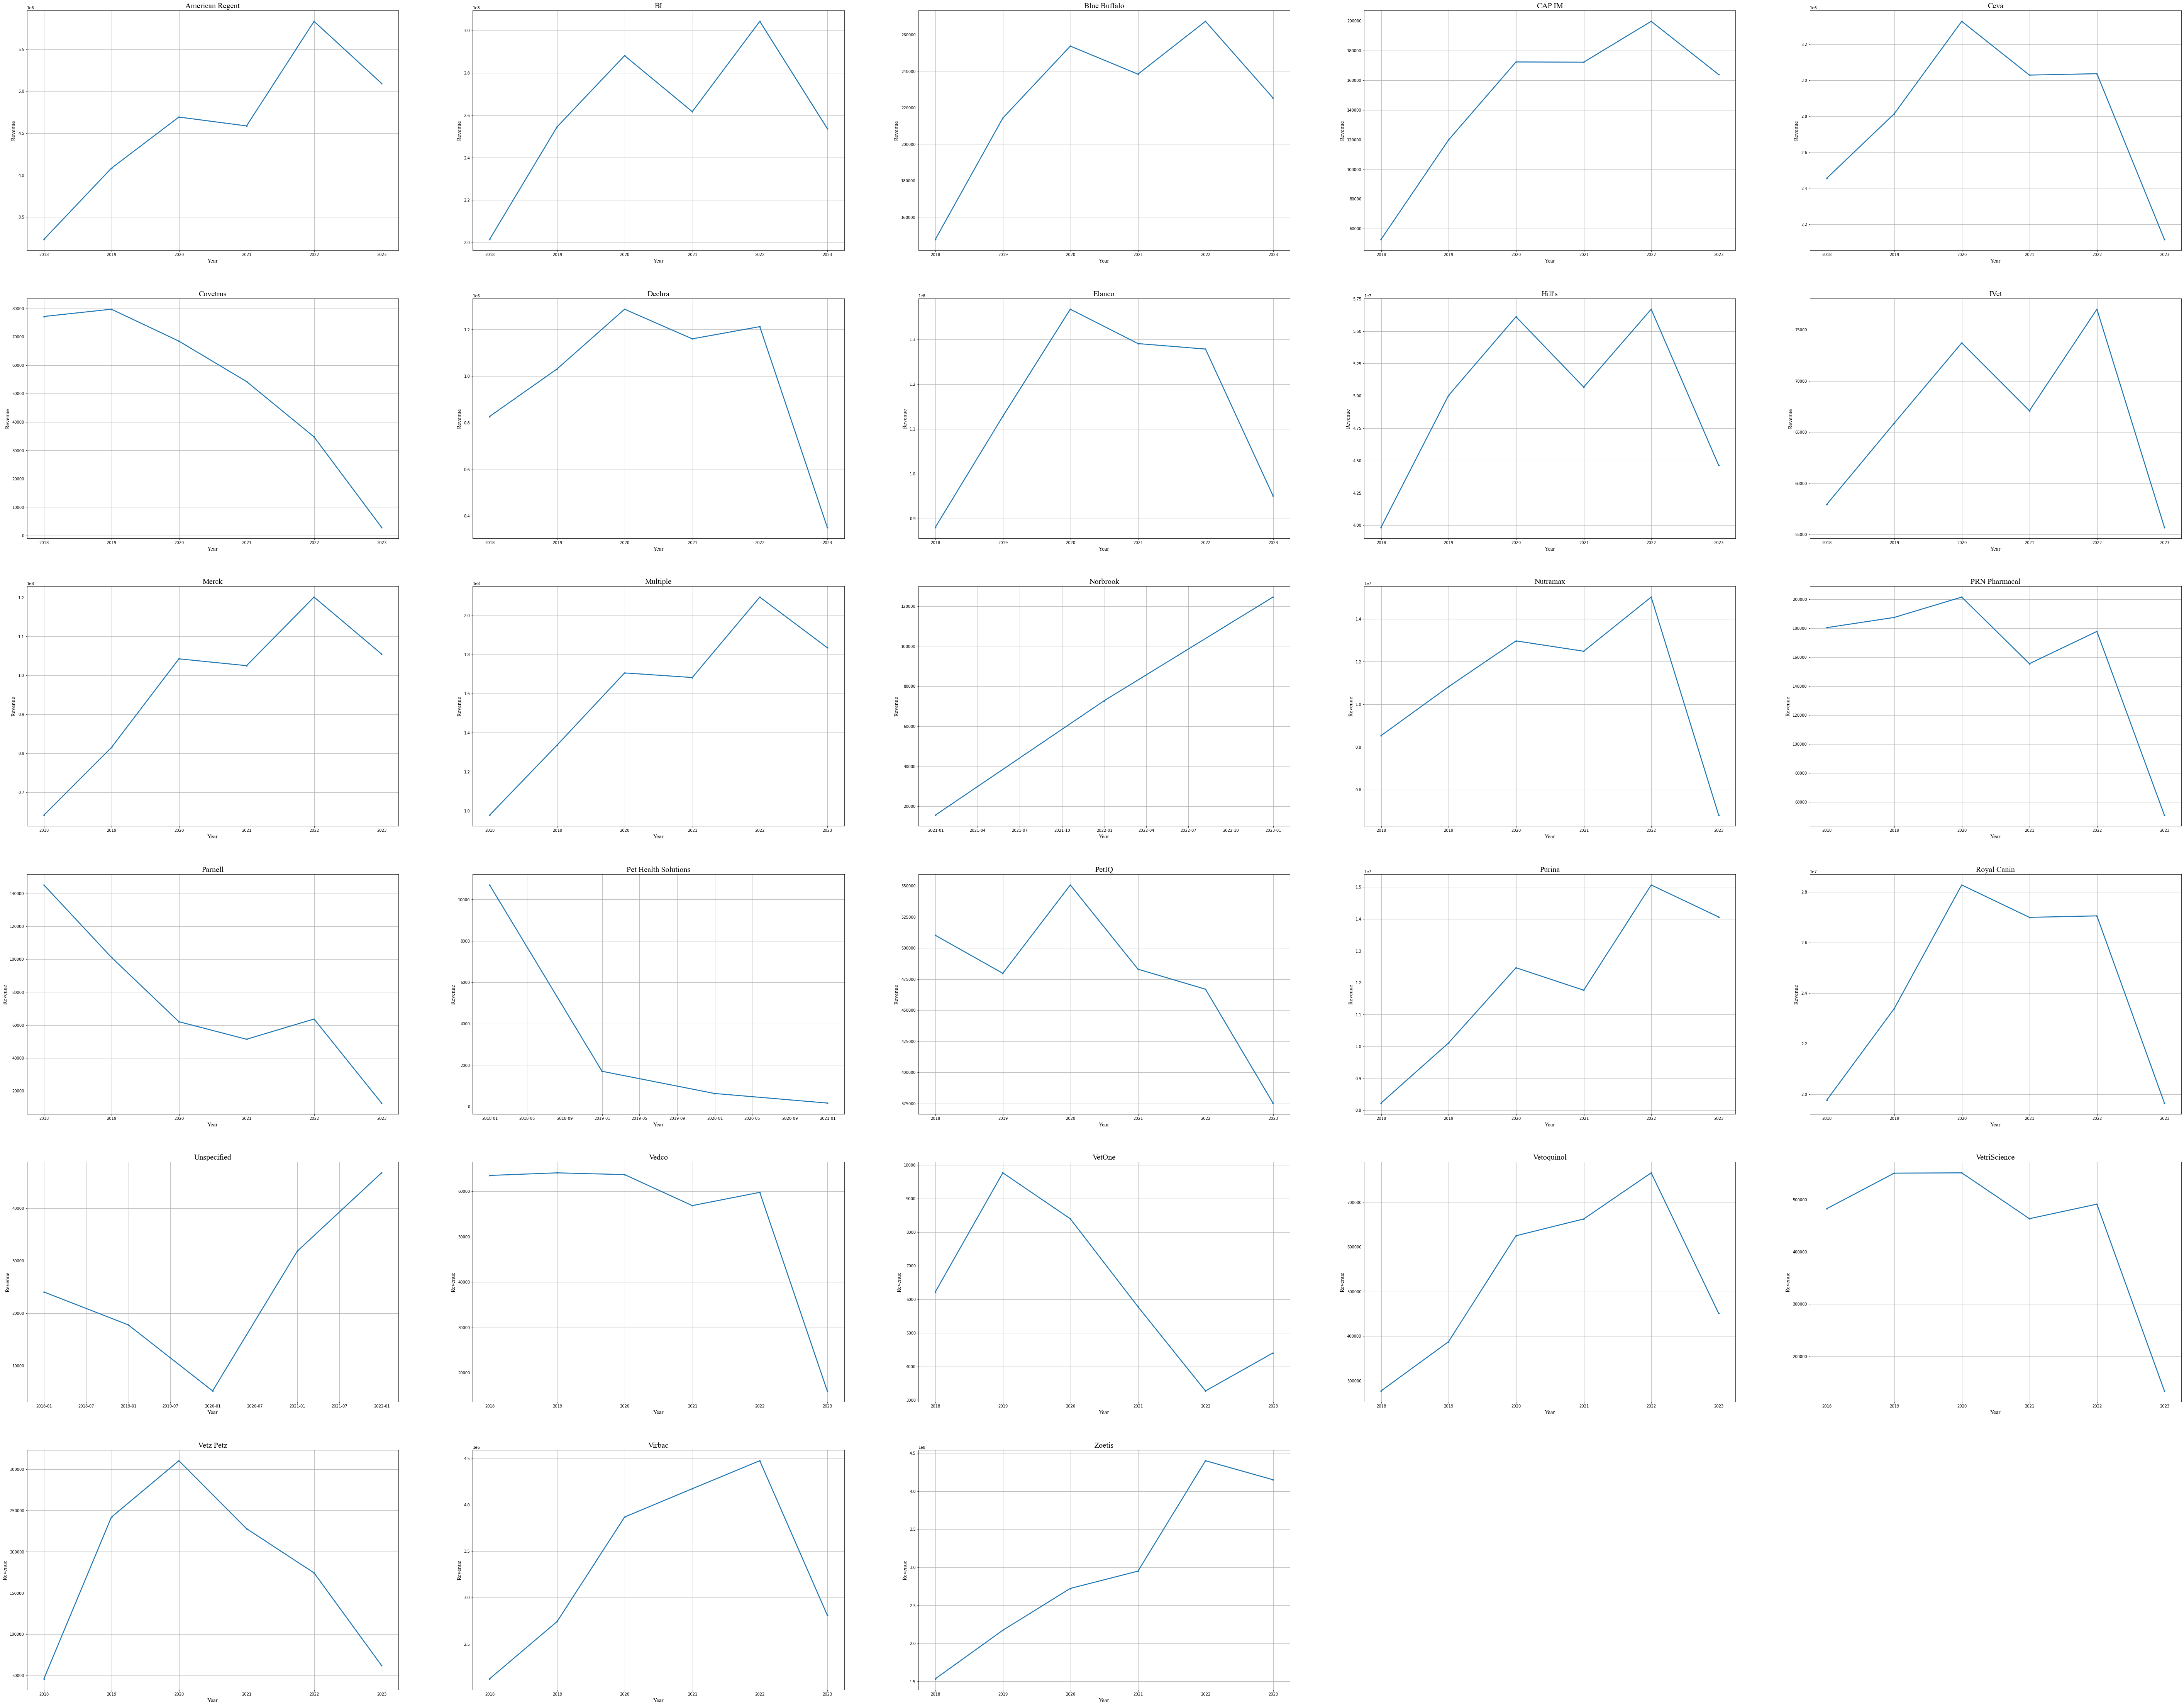

In [12]:
# # get manufacturer list
# table = mfg_Monthly_Sales.groupby(['icms_rep_mfg'],as_index=False).count()
# table = table['icms_rep_mfg']
# mfg = table.values.tolist()
#
# # plot graph of monthly revenue and selling units for each manufacturer
# plt.figure(figsize=(80, 30))
# count = 1
# for company in mfg:
#     plt.subplot(6, 5, count)
#     plt.plot(mfg_Monthly_Sales[mfg_Monthly_Sales['icms_rep_mfg'] == company].groupby(['post_month'])[['units', 'revenue']].sum())
#     plt.title(company)
#     count+=1

table = mfg_Monthly_Sales.groupby(['icms_rep_mfg'],as_index=False).count()
table = table['icms_rep_mfg']
mfg = table.values.tolist()

font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size' : 20,
         }
font2 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size' : 15,
         }
# plot graph of monthly revenue and selling units for each manufacturer
plt.figure(figsize=(100, 80))
count = 1
for company in mfg:
    plt.subplot(6, 5, count)
    table = without_outlier[without_outlier['icms_rep_mfg'] == company]
    table = table.loc[(table['post_month'].dt.month == 1) | (table['post_month'].dt.month == 2) | (table['post_month'].dt.month == 3) | (table['post_month'].dt.month == 4) | (table['post_month'].dt.month == 5) | (table['post_month'].dt.month == 6)]
    table.set_index('post_month', inplace=True)
    table = table.resample('Y').sum()
    pd.DataFrame(table)
    plt.grid()
    plt.plot(table['revenue'], '.-', linewidth=2.5)
    plt.xlabel('Year', font2)
    plt.ylabel('Revenue', font2)
    plt.title(company, font1)
    count+=1

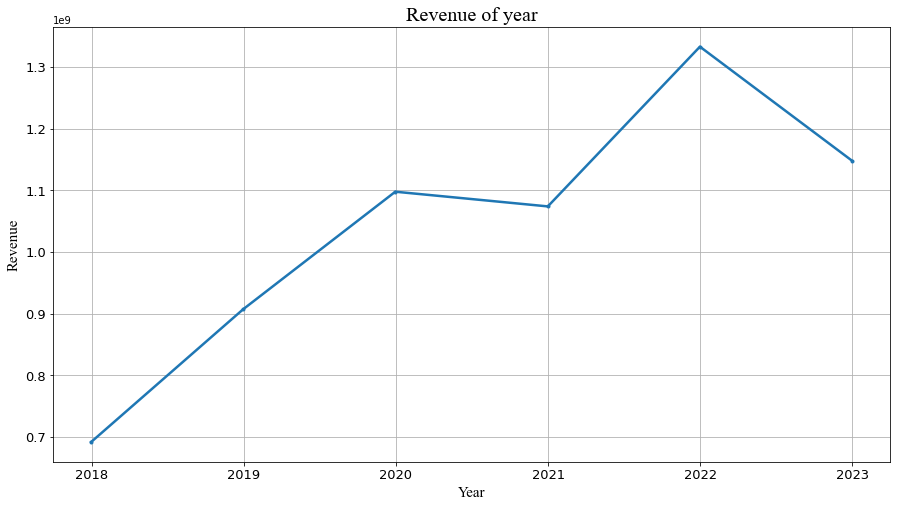

In [13]:
total_revenue = without_outlier.groupby(['post_month'], as_index=False)['revenue'].sum()
total_revenue = total_revenue.loc[(total_revenue['post_month'].dt.month == 1) | (total_revenue['post_month'].dt.month == 2) | (total_revenue['post_month'].dt.month == 3) | (total_revenue['post_month'].dt.month == 4) | (total_revenue['post_month'].dt.month == 5) | (total_revenue['post_month'].dt.month == 6)]
total_revenue.set_index('post_month', inplace=True)
total_revenue = total_revenue.resample('Y').sum()
plt.figure(figsize=(15, 8))
plt.tick_params(labelsize=13)
plt.plot(total_revenue, '.-', linewidth=2.5)
plt.xlabel('Year', font2)
plt.ylabel('Revenue', font2)
plt.title('Revenue of year', font1)
plt.grid()
plt.savefig('total_halfyear.png')

In [14]:
total_revenue

,revenue
post_month,
2017-12-31,6.918899e+08
2018-12-31,9.072896e+08
2019-12-31,1.097850e+09
2020-12-31,1.074026e+09
2021-12-31,1.333047e+09
2022-12-31,1.148113e+09


In [15]:
without_outlier

,post_month,source_id,account_id,icms_rep_brand,icms_form,icms_rep_mfg,patient_age_type,rep_category_ids,units,revenue,unit_price,scores,anomaly
1,2017-01-01,0,1003,Acepromazine,Pill,Multiple,Adult,[250],33.0,74.85,2.268182,0.092650,1
2,2017-01-01,0,1003,A/D,Wet,Hill's,Adult,[210],12.0,41.76,3.480000,0.111914,1
3,2017-01-01,0,1003,Amitriptyline,Pill,Multiple,Adult,[260],60.0,34.50,0.575000,0.160651,1
4,2017-01-01,0,1003,Amoxicillin Clavulanate,Pill,Multiple,Adult,[230],134.0,274.80,2.050746,0.144380,1
5,2017-01-01,0,1003,Apoquel,Pill,Zoetis,Adult,[220],1822.0,4371.95,2.399533,0.078834,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39503561,2022-07-01,2,9999,Urinary SO MC,Dry,Royal Canin,Adult,[210],1.0,46.44,46.440000,0.087900,1
39503562,2022-07-01,2,9999,Vectra 3D,Topical,Ceva,Adult,[1],21.0,473.37,22.541429,0.147241,1
39503563,2022-07-01,2,9999,Vectra 3D,Topical,Ceva,Non-adult,[1],2.0,40.06,20.030000,0.166939,1
39503564,2022-07-01,2,9999,W/D,Wet,Hill's,Adult,[210],10.0,38.90,3.890000,0.119634,1
